# Numerical solution of the Fokker-Planck Equation

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## Harmonic-Oscillator

#### The Fokker Planck equation for the phase space probability distribution of the noisy harmonic oscillator reads
$$
\frac{\partial w(\xi_i,t)}{\partial t}=-D_i\frac{\partial w(\xi_i,t)}{\partial\xi_i}+
D_{ij}\frac{\partial^2 w(\xi_i,t)}{\partial\xi_i\partial\xi_j}
$$
with the vector $\mathbf{\xi}=(x,v)^T$

#### In the case of a harmonic oscillator we have
$$
\frac{\partial w(x,v,t)}{\partial t}=-v\frac{\partial w(x,v,t)}{\partial x}+
(x+\gamma v)\frac{\partial w(x,v,t)}{\partial v}+\gamma w(x,v,t)+
c\frac{\partial^2 w(x,v,t)}{\partial v^2}
$$
In terms of finite differences with Euler forward we have
$$
w(x,v,t+\Delta t)=(1+\gamma\cdot\Delta t)\cdot w(x,v,t)-v\frac{w(x+\Delta x,v,t)-w(x-\Delta x,v,t)}{2\Delta x}
+(x+\gamma v)\frac{w(x,v+\Delta v,t)-w(x,v-\Delta v,t)}{2\Delta v}
+c\frac{w(x,v+\Delta v,t)-2\cdot w(x,v,t)+w(x,v-\Delta v,t)}{\Delta v^2}
$$

In [2]:
bins = 200

x_1, x_2 = np.meshgrid(np.linspace(-1, 1, bins), np.linspace(-1, 1, bins))
wxv = np.zeros((bins, bins))

x, v = x_1, x_2

wxv[75:125, 75:125] = 100

In [3]:
frames = []

In [1067]:
%matplotlib notebook
# HO FPE
dt = 0.1
gamma = 0.01
c = 1.0

for i in np.arange(10000):
    if i % 1000 == 0 or (i < 2000 and i % 100 == 0):
        frames.append(wxv * 1)

    dwdx = (np.roll(wxv, -1, 1) - np.roll(wxv, 1, 1)) / 2.
    dwdv = (np.roll(wxv, -1, 0) - np.roll(wxv, 1, 0)) / 2.
    d2wdv2 = np.roll(wxv, -1, 0) - 2. * wxv + np.roll(wxv, 1, 0)
    
    # Greiners:
    wxv[1:-2,1:-2] = ((1.0 + gamma * dt) * wxv - v * dwdx * dt + (x + gamma * v) * dwdv * dt + c * d2wdv2 * dt)[1:-2,1:-2]

    # Kostelezkys: --but w/o external potential f'(x) = x
    #wxv[1:-2,1:-2] = ((\
    #                  - dwdx * x_2 + dwdv * (x_1 + gamma * x_2) + d2wdv2 * c \
    #                  ) * dt + wxv)[1:-2,1:-2]

## Van-der-Pol-oscillator

In [2]:
# upwind schemes implementation
# kinda hard-coded here

def first_order_upwind(wxv, dx):
    '''calculates first order upwind derivate of 2d-field wxv.
    Particularly programmed for probability field W in the Fokker-Planck-Equation.
    
    returns as tuple:
        - derivates of wxv:
        [0] dwdx_pos: forward-derivate (positive direction) in axis (1, 0)
        [1] dwdx_neg: backwars-derivate (negative direction) in axis (1, 0)
        [2] dwdv_pos: forward-derivate (positive direction) in axis (0, 1)
        [3] dwdv_neg: backwars-derivate (negative direction) in axis (0, 1)
        
    Usage:
    >>> dwdx_pos, dwdx_neg, dwdv_pos, dwdv_neg = first_order_upwind(wxv, dx)
    '''
    dwdx_pos = (wxv - np.roll(wxv, shift=(1, 0), axis=(1, 0))) / dx
    dwdx_neg = (np.roll(wxv, shift=(-1, 0), axis=(1, 0)) - wxv) / dx

    dwdv_pos = (wxv - np.roll(wxv, shift=(0, 1), axis=(1, 0))) / dx
    dwdv_neg = (np.roll(wxv, shift=(0, -1), axis=(1, 0)) - wxv) / dx
    
    return dwdx_pos, dwdx_neg, dwdv_pos, dwdv_neg

def second_order_upwind(wxv, dx):
    '''calculates second order upwind derivate of 2d-field wxv.
    Particularly programmed for probability field W in the Fokker-Planck-Equation.
    
    returns as tuple:
        - derivates of wxv:
        [0] dwdx_pos: forward-derivate (positive direction) in axis (1, 0)
        [1] dwdx_neg: backwars-derivate (negative direction) in axis (1, 0)
        [2] dwdv_pos: forward-derivate (positive direction) in axis (0, 1)
        [3] dwdv_neg: backwars-derivate (negative direction) in axis (0, 1)
        
    Usage:
    >>> dwdx_pos, dwdx_neg, dwdv_pos, dwdv_neg = second_order_upwind(wxv, dx)
    '''
    dwdx_pos = (- 3 * wxv \
                + 4 * np.roll(wxv, shift=(-1, 0), axis=(1, 0)) \
                - np.roll(wxv, shift=(-2, 0), axis=(1, 0)) \
               ) / (2 * dx)
    dwdx_neg = (+ 3 * wxv \
                - 4 * np.roll(wxv, shift=(1, 0), axis=(1, 0)) \
                + np.roll(wxv, shift=(2, 0), axis=(1, 0)) \
               ) / (2 * dx)

    dwdv_pos = (- 3 * wxv \
                + 4 * np.roll(wxv, shift=(0, -1), axis=(1, 0)) \
                - np.roll(wxv, shift=(0, -2), axis=(1, 0)) \
               ) / (2 * dx)
    dwdv_neg = (+ 3 * wxv \
                - 4 * np.roll(wxv, shift=(0, 1), axis=(1, 0)) \
                + np.roll(wxv, shift=(0, 2), axis=(1, 0)) \
               ) / (2 * dx)
    return dwdx_pos, dwdx_neg, dwdv_pos, dwdv_neg

def third_order_upwind():
    '''calculates second order upwind derivate of 2d-field wxv.
    Particularly programmed for probability field W in the Fokker-Planck-Equation.
    
    returns as tuple:
        - derivates of wxv:
        [0] dwdx_pos: forward-derivate (positive direction) in axis (1, 0)
        [1] dwdx_neg: backwars-derivate (negative direction) in axis (1, 0)
        [2] dwdv_pos: forward-derivate (positive direction) in axis (0, 1)
        [3] dwdv_neg: backwars-derivate (negative direction) in axis (0, 1)
        
    Usage:
    >>> dwdx_pos, dwdx_neg, dwdv_pos, dwdv_neg = third_order_upwind(wxv, dx)
    '''
    dwdx_pos = (- 2 * np.roll(wxv, shift=(1, 0), axis=(1, 0)) \
                - 3 * wxv \
                + 6 * np.roll(wxv, shift=(-1, 0), axis=(1, 0)) \
                - np.roll(wxv, shift=(-2, 0), axis=(1, 0))
               ) / (6 * dx)
    dwdx_neg = (+ 2 * np.roll(wxv, shift=(-1, 0), axis=(1, 0)) \
                + 3 * wxv \
                - 6 * np.roll(wxv, shift=(1, 0), axis=(1, 0)) \
                + np.roll(wxv, shift=(2, 0), axis=(1, 0))
               ) / (6 * dx)

    dwdv_pos = (- 2 * np.roll(wxv, shift=(0, 1), axis=(1, 0)) \
                - 3 * wxv \
                + 6 * np.roll(wxv, shift=(0, -1), axis=(1, 0)) \
                - np.roll(wxv, shift=(0, -2), axis=(1, 0))
               ) / (6 * dx)
    dwdv_neg = (+ 2 * np.roll(wxv, shift=(0, -1), axis=(1, 0)) \
                + 3 * wxv \
                - 6 * np.roll(wxv, shift=(0, 1), axis=(1, 0)) \
                + np.roll(wxv, shift=(0, 2), axis=(1, 0))
               ) / (6 * dx)

    return dwdx_pos, dwdx_neg, dwdv_pos, dwdv_neg

In [101]:
bins = 200
interval = (-4, 4)
dx = (max(interval) - min(interval)) / bins

x_1, x_2 = np.meshgrid(np.linspace(min(interval), max(interval), bins), np.linspace(min(interval), max(interval), bins))
wxv = np.zeros((bins, bins))

# This choice of parameters follows Gadisek, et.al. PRE62, p. 3155 (2000)
mu = 1
epsilon = 2
omega = 1

d_x = x_2
d_v = mu * (epsilon - x_1 ** 2) * x_2 - (omega ** 2) * x_1

#wxv[75:125, 145:195] = 100 # "rechts"
#wxv[75:125, 75:125] = 100 # "mitte"
#wxv[75:125, 5:55] = 100 # "links"

wxv = np.exp(- 2 * x_1 ** 2 - 2 * x_2 ** 2)

<IPython.core.display.Javascript object>


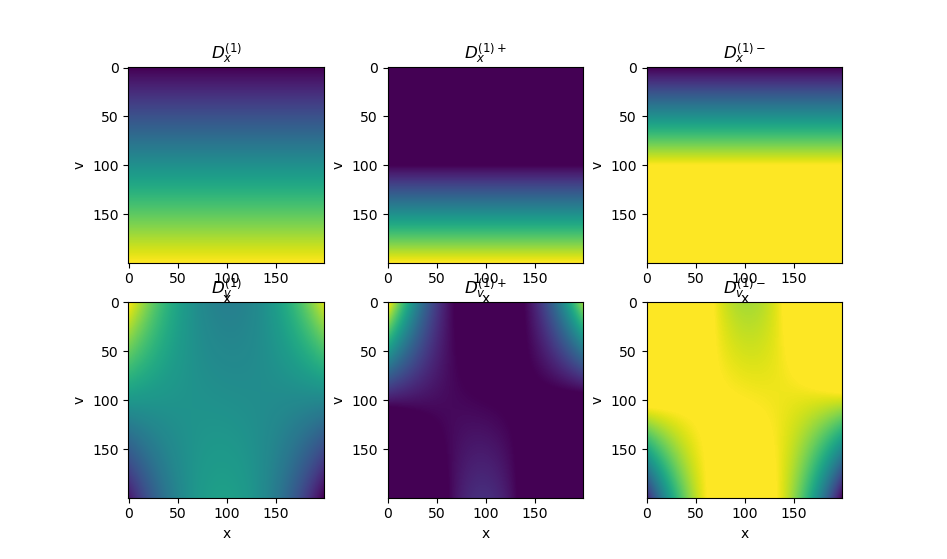

In [83]:
# upwind scheme
d_x_pos = np.array(d_x)
d_x_pos[d_x_pos < 0] = 0 # all negative values of d_x are replaced by 0

d_x_neg = np.array(d_x)
d_x_neg[d_x_neg >= 0] = 0 # all positive values of d_x are replaced by 0 including 0

# looks great! now do the same with d_v
d_v_pos = np.array(d_v)
d_v_pos[d_v_pos < 0] = 0 # all negative values of d_x are replaced by 0

d_v_neg = np.array(d_v)
d_v_neg[d_v_neg >= 0] = 0 # all positive values of d_x are replaced by 0 including 0

%matplotlib notebook
for t, v, i in [('$D_{x}^{(1)}$', d_x, 1), ('$D_{x}^{(1)+}$', d_x_pos, 2), ('$D_{x}^{(1)-}$', d_x_neg, 3),
               ('$D_{v}^{(1)}$', d_v, 4), ('$D_{v}^{(1)+}$', d_v_pos, 5), ('$D_{v}^{(1)-}$', d_v_neg, 6)]:
    plt.subplot(2, 3, i)
    plt.imshow(v)
    plt.title(t)
    plt.xlabel('x')
    plt.ylabel('v')
plt.show()

<IPython.core.display.Javascript object>


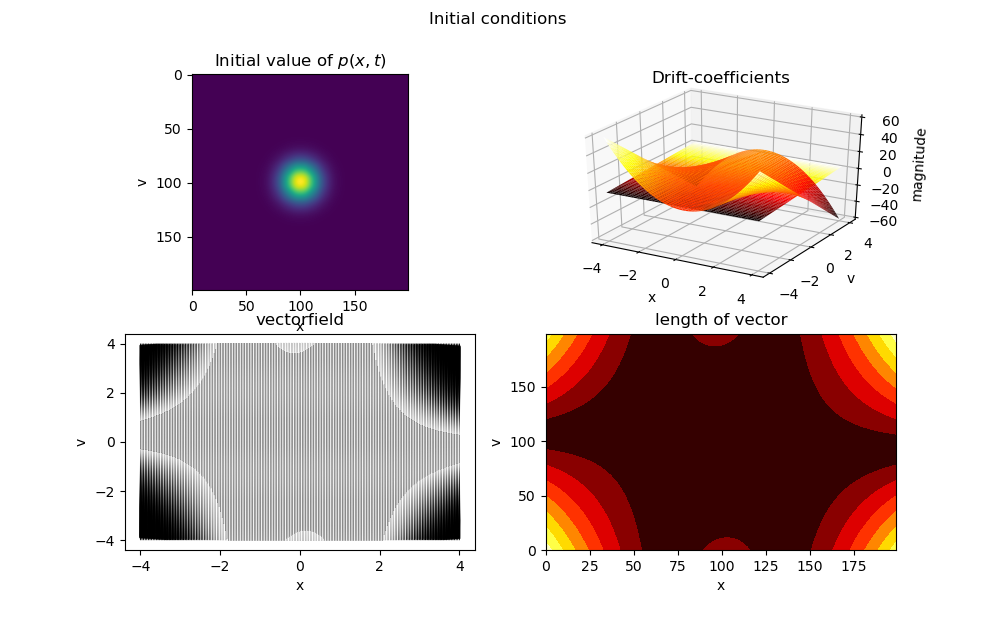

In [5]:
%matplotlib notebook
fig = plt.figure()
fig.suptitle('Initial conditions')

ax = fig.add_subplot(2, 2, 1)
ax.set_title('Initial value of $p(x, t)$')
ax.set_xlabel('x')
ax.set_ylabel('v')
ax.imshow(wxv)
#ax.colorbar()

ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.set_title('Drift-coefficients')
ax.set_xlabel('x')
ax.set_ylabel('v')
ax.set_zlabel('magnitude')
ax.plot_surface(x_1, x_2, d_x, label='x', cmap='hot')
ax.plot_surface(x_1, x_2, d_v, label='v', cmap='hot')
#ax.legend()

ax = fig.add_subplot(2, 2, 3)
q = ax.quiver(x_1, x_2, d_x, d_v)
ax.set_title('vectorfield')
ax.set_xlabel('x')
ax.set_ylabel('v')

ax = fig.add_subplot(2, 2, 4)
ax.set_title('length of vector')
ax.contourf(np.sqrt(d_x ** 2 + d_v ** 2), cmap='hot')
ax.set_xlabel('x')
ax.set_ylabel('v')

plt.show()

In [15]:
# checking for Courant–Friedrichs–Lewy condition
c_x = np.abs(d_x * dt / dx)
c_v = np.abs(d_v * dt / dx)

print(c_x.all() <= 1)
print(c_v.all() <= 1)

True
True


In [102]:
frames = []

In [103]:
%matplotlib notebook
# VdP FPE
dt = 0.00001
g = 1

for i in np.arange(100000):
    if i % 1000 == 0 or (i < 2000 and i % 100 == 0):
        frames.append(wxv * 1)

    # first order upwind
    dwdx_pos, dwdx_neg, dwdv_pos, dwdv_neg = first_order_upwind(wxv, dx)

    # second order upwind
    # dwdx_pos, dwdx_neg, dwdv_pos, dwdv_neg = second_order_upwind(wxv, dx)

    # third order upwind
    # dwdx_pos, dwdx_neg, dwdv_pos, dwdv_neg = third_order_upwind(wxv, dx)

    # this one is implemented just as in FPEUpwind.pdf
    d2wdv2 = (np.roll(wxv, shift=(0, -1), axis=(1, 0)) - 2 * wxv + np.roll(wxv, shift=(0, 1), axis=(1, 0))) / (dx ** 2)

    # now composite them
    # we no longer need periodic boundary conditions [1:-2, 1:-2] due to using neumann boundary conditions
    wxv = ((\
                        - (epsilon - x_1 ** 2) * wxv + (g / 2) * d2wdv2 \
                        - d_x_pos * dwdx_pos - d_x_neg * dwdx_neg \
                        - d_v_pos * dwdv_pos - d_v_neg * dwdv_neg \
                       ) * dt + wxv)
    
    # IST DAS VALIDE WAS ICH HIER MACHE?
    # Simulationsgebiet vergrößern und verkleinern
    
    # applying Neumann boundary conditions: "reflecting boundaries"
    neumann = lambda x_1, x_2: (4 * x_1 - x_2) / 3
    
    for j in range(bins):
        if d_x[2][j] >= 0:
            wxv[2][j] = neumann(wxv[3][j], wxv[4][j]) ##
        else:
            wxv[2][j] = neumann(wxv[1][j], wxv[0][j]) ##
        
        if d_x[-3][j] >= 0:
            wxv[-3][j] = neumann(wxv[-2][j], wxv[-1][j])
        else:
            wxv[-3][j] = neumann(wxv[-4][j], wxv[-5][j])
            
        if d_v[j][2] >= 0:
            wxv[j][2] = neumann(wxv[j][1], wxv[j][0])
        else:
            wxv[j][2] = neumann(wxv[j][3], wxv[j][4])        
        
        if d_v[j][-3] >= 0:
            wxv[j][-3] = neumann(wxv[j][-2], wxv[j][-1])
        else:
            wxv[j][-3] = neumann(wxv[j][-4], wxv[j][-5])

## Visualization

<IPython.core.display.Javascript object>


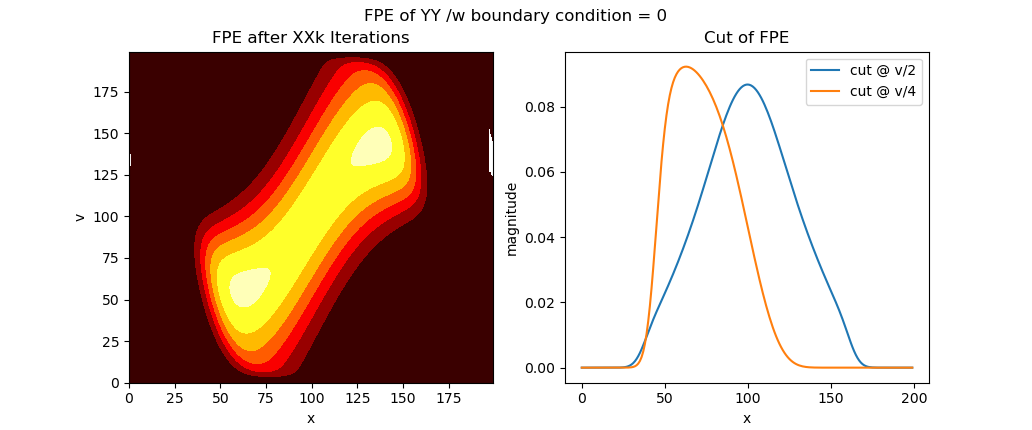

In [104]:
%matplotlib notebook
fig = plt.figure()
fig.suptitle('FPE of YY /w boundary condition = 0')

ax = fig.add_subplot(1, 2, 1)
ax.set_title('FPE after XXk Iterations')
ax.set_xlabel('x')
ax.set_ylabel('v')
ax.contourf(wxv, cmap='hot')

ax = fig.add_subplot(1, 2, 2)
ax.set_title('Cut of FPE')
ax.set_xlabel('x')
ax.set_ylabel('magnitude')
ax.plot(wxv[bins//2], label='cut @ v/2')
ax.plot(wxv[bins//4], label='cut @ v/4')
ax.legend()

plt.show()

### Animation

In [11]:
import matplotlib.animation as animation

In [105]:
fig, ax = plt.subplots()

print(len(frames))

def animate(i):
    fig.clear()
    ax = fig.add_subplot(1, 2, 1)
    ax.set_title('FPE after ca.%03d Iterations'%(i * 1000))
    ax.set_xlabel('x')
    ax.set_ylabel('v')
    ax.contourf(frames[i])

    ax = fig.add_subplot(1, 2, 2)
    ax.set_title('Cut of FPE')
    ax.set_xlabel('x')
    ax.set_ylabel('magnitude')
    ax.plot(frames[i][bins//2], label='cut @ v/2')
    ax.plot(frames[i][bins//4], label='cut @ v/4')
    ax.legend()
    
    #fig.savefig('./misc/outputs/%s.png'% (i))
    
interval = 50
ani = animation.FuncAnimation(fig, animate, interval=interval, blit=False, frames=len(frames), repeat_delay=2500)

plt.show()

<IPython.core.display.Javascript object>

118
